In [1]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
import six
from sklearn.metrics import roc_curve
import datetime
%matplotlib inline

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [3]:
comData = np.load("../inData/comData.npy")
comClass = np.load("../inData/comClass.npy")

In [4]:
def processClassData(classData):
    """
    Process classData.
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

comData = comData[..., np.newaxis]
comClassOH = processClassData(comClass)

In [5]:
# kfold x-validation...
k = 3
kfoldData = np.array_split(comData, k)
kfoldLabelsOH = np.array_split(comClassOH, k)
kfoldLabels = np.array_split(comClass, k)
print(kfoldData[0].shape)

(134, 2000, 19, 17, 1)


# Neural Network

In [6]:
spec = []
sens = []
roc = []

In [ ]:
subsamp = 40

In [ ]:
for i in np.arange(0,k,1):
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, 22, 19, 17, 1])

    # First layer:
    net = tflearn.layers.conv.conv_3d(net, 8, [5,5,5],  activation="leaky_relu", \
                                      regularizer='L2', weight_decay=0.001)
    net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

    # Second layer:
    net = tflearn.layers.conv.conv_3d(net, 16, [5,5,5], activation="leaky_relu", \
                                      regularizer='L2', weight_decay=0.001)
    net = tflearn.layers.conv.max_pool_3d(net, 2, strides=2)

    # Fully connected layer
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", \
                                              weight_decay=0.001, activation="leaky_relu")
    #net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", \
    #                                          weight_decay=0.001, activation="leaky_relu")
    
    # Dropout layer:
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

    net = tflearn.layers.estimator.regression(net, optimizer='adam', \
                                              learning_rate=0.0001, loss='categorical_crossentropy')
    #Could use loss function: 'roc_auc_score'
    
    model = tflearn.DNN(net, tensorboard_verbose=3)
    
    dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 2000, 19, 17, 1])
    dummyData = dummyData[:,1120:][:,::40]
    dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
    
    illTest = []
    healthTest = []
    for index, item in enumerate(kfoldLabels[i]):
        if item == 1:
            illTest.append(kfoldData[i][index])
        if item == 0:
            healthTest.append(kfoldData[i][index])
    healthLabel = np.tile([1,0], (len(healthTest), 1))
    illLabel = np.tile([0,1], (len(illTest), 1))
    
    model.fit(dummyData, dummyLabels, batch_size=8, n_epoch=30, show_metric=True)

    sens.append(model.evaluate(np.array(healthTest)[:,1120:][:,::40], healthLabel))
    spec.append(model.evaluate(np.array(illTest)[:,1120:][:,::40], illLabel))

    # Get roc curve data
    predicted = np.array(model.predict(np.array(kfoldData[i])[:,1120:][:,::40]))
    fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
    roc.append([fpr, tpr])

---------------------------------
Run id: 8FDIM3
Log directory: /tmp/tflearn_logs/


In [ ]:
#model.save("./outData/models/3d_conv8-16-50.tflearn")
#model.load("./outData/models/3d_conv.tflearn")

Specificity: [[0.77464789152145386], [0.93442624807357788], [0.8125]] 
Avg: 0.840524713198 
Sensitivity: [[0.8095238208770752], [0.77777779102325439], [0.85507243871688843]] 
Avg: 0.814124683539


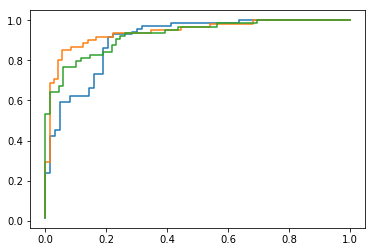

In [8]:
print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens))
for i in np.arange(k):
    plt.plot(roc[i][0], roc[i][1])

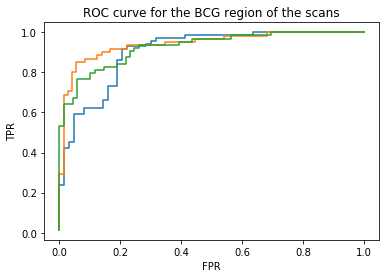

In [9]:
for i in np.arange(k):
    plt.plot(roc[i][0], roc[i][1])
    
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve for the BCG region of the scans")
plt.savefig("/Users/controller/Desktop/roc_BCG1FC.png")

## Hyperparameter Optimisation

We could potentially optimise:
    * Regression layer learning rate
    * Filter shape
    * Pooling shape and stride
    * Weight decay of regulariser (in Conv layer & Fully connected layers)
    * Subsamp